In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from image_tabular.core import *
from image_tabular.metric import *

# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
data_path = Path("./data/siim-isic-melanoma-classification/")

In [5]:
train_df = pd.read_csv(data_path/"train.csv")
test_df = pd.read_csv(data_path/"test.csv")

print(len(train_df), len(test_df))

33126 10982


In [6]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
# extremely unbalanced dataset, most of the images are benign
train_df["target"].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

## Image data

In [8]:
tfms = get_transforms(flip_vert=True)
size = 128
bs = 64

In [9]:
# idx for validation
val_idx = get_valid_index(train_df)
len(val_idx)

6625

In [10]:
# load image data using train_df and prepare fastai LabelLists
image_data = (ImageList.from_df(train_df, path=data_path, cols="image_name",
                               folder="train_128", suffix=".jpg")
              .split_by_idx(val_idx)
              .label_from_df(cols="target")
              .transform(tfms, size=size)
              .databunch(bs=bs).normalize(imagenet_stats))

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=data_path, cols="image_name",
                                    folder="test_128", suffix=".jpg")
image_data.add_test(test_image_data)

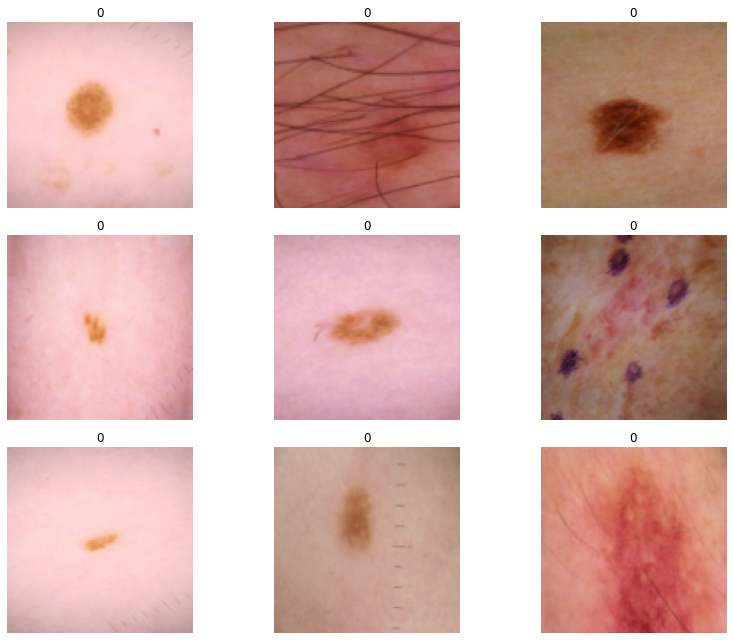

In [11]:
# show some example images
image_data.show_batch(rows=3, figsize=(12, 9))

In [12]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [13]:
# package everything in a fastai learner, add auc roc score as a metric
learn = cnn_learner(image_data, models.resnet50, lin_ftrs=[512, 256, 32], ps=0.2,
                    metrics=[accuracy, ROCAUC()], loss_func=loss_func)

## Training

epoch,train_loss,valid_loss,accuracy,rocauc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


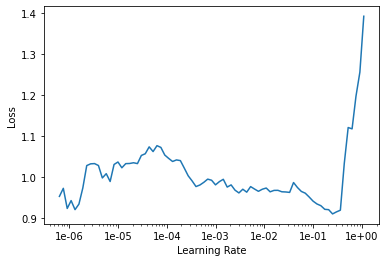

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
# train
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.950532,0.765059,0.542792,0.698266,00:37
1,0.802611,0.702814,0.567547,0.774017,00:57
2,0.708451,0.581417,0.676377,0.803731,00:59
3,0.684570,0.546593,0.715925,0.816741,01:01
4,0.606639,0.504372,0.757736,0.839341,01:01
5,0.560482,0.500031,0.783547,0.843033,01:01
6,0.536991,0.483945,0.775245,0.853313,01:02
7,0.497213,0.495452,0.789585,0.842114,01:02
8,0.524316,0.492208,0.811472,0.839900,01:01
9,0.465211,0.491071,0.824000,0.840230,01:04


In [16]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.484332,0.472027,0.827925,0.855899,01:27
1,0.494951,0.518502,0.846641,0.814634,01:26
2,0.478752,0.489155,0.823396,0.838094,01:28
3,0.476490,0.463134,0.823245,0.855332,01:27
4,0.474404,0.464166,0.826868,0.854111,01:27


## Prediction

In [17]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [18]:
# submit predictions to kaggle
submit = pd.read_csv(data_path/"sample_submission.csv")
submit["target"] = preds[:, 1]
submit.to_csv(data_path/"image.csv", index=False)